ZhongXu has asked that I make him the HODs from the SHAMs I made him. This should be pretty straightforward so I'll do it quickly here.  

In [1]:
import numpy as np
import astropy
from pearce.mocks import cat_dict
from pearce.mocks.assembias_models.table_utils import compute_prim_haloprop_bins
import h5py

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from itertools import cycle

In [3]:
%%bash
ls /home/users/swmclau2/scratch/*mpeak*.hdf5 -ltr

-rw-rw-r-- 1 swmclau2 kipac   28562856 Dec 18  2017 /home/users/swmclau2/scratch/catalog_ab_halo_vmax@mpeak_shuffled.hdf5
-rw-rw-r-- 1 swmclau2 kipac   35284192 Feb  8 11:36 /home/users/swmclau2/scratch/catalog_ab_halo_vmax@mpeak.hdf5
-rw-rw-r-- 1 swmclau2 kipac   35284192 Apr  9 14:49 /home/users/swmclau2/scratch/catalog_ab_halo_mpeak_shuffled.hdf5
-rw-r--r-- 1 swmclau2 kipac   35284192 May 28 14:40 /home/users/swmclau2/scratch/catalog_ab_halo_mpeak.hdf5
-rw-r--r-- 1 swmclau2 kipac 8061416824 May 28 21:47 /home/users/swmclau2/scratch/catalog_ab_halo_mpeak_large.hdf5
-rw-r--r-- 1 swmclau2 kipac 8061416824 May 29 11:57 /home/users/swmclau2/scratch/catalog_ab_halo_mpeak_largev2.hdf5
-rw-r--r-- 1 swmclau2 kipac 8061416824 May 29 18:34 /home/users/swmclau2/scratch/catalog_ab_halo_mpeak_large_v3.hdf5
-rw-r--r-- 1 swmclau2 kipac 8061416824 May 30 10:57 /home/users/swmclau2/scratch/catalog_ab_halo_mpeak_large_fixed.hdf5
-rw-r--r-- 1 swmclau2 kipac   35284192 May 31 10:33 /home/users/swmclau2/

In [4]:
fname = '/home/users/swmclau2/scratch/catalog_ab_halo_mpeak_fixed.hdf5'

In [5]:
from collections import Counter
def compute_occupations(halo_catalog, galaxy_catalog):
    #halo_table = cat.halocat.halo_table[cat.halocat.halo_table['halo_mvir'] > min_ptcl*cat.pmass]

    cens_occ = np.zeros((np.sum(halo_catalog['halo_upid'] == -1),))
    #cens_occ = np.zeros((len(halo_table),))
    sats_occ = np.zeros_like(cens_occ)
    detected_central_ids = set(galaxy_catalog[galaxy_catalog['halo_upid']==-1]['halo_id'])
    detected_satellite_upids = Counter(galaxy_catalog[galaxy_catalog['halo_upid']!=-1]['halo_upid'])

    for idx, row  in enumerate(halo_catalog[halo_catalog['halo_upid'] == -1]):
        if idx%1000000 == 0:
            print idx
            
        cens_occ[idx] = 1.0 if row['halo_id'] in detected_central_ids else 0.0
        sats_occ[idx]+= detected_satellite_upids[row['halo_id']]

    return cens_occ, sats_occ

In [6]:
from math import ceil
def compute_mass_bins(prim_haloprop, dlog10_prim_haloprop=0.05):   
    lg10_min_prim_haloprop = np.log10(np.min(prim_haloprop))-0.001
    lg10_max_prim_haloprop = np.log10(np.max(prim_haloprop))+0.001
    num_prim_haloprop_bins = (lg10_max_prim_haloprop-lg10_min_prim_haloprop)/dlog10_prim_haloprop
    return np.logspace(
        lg10_min_prim_haloprop, lg10_max_prim_haloprop,
        num=int(ceil(num_prim_haloprop_bins)))

In [7]:
Lbox = 1000.0
nd = 4.2e-4
num_obj = nd*(Lbox**3)

In [8]:
scratch_path = '/home/users/swmclau2/scratch/'
halo_catalog = astropy.table.Table.read(fname, format = 'hdf5')

In [9]:
non_nan_idxs = ~np.isnan(halo_catalog['gal_smass'])
all_smass = halo_catalog['gal_smass'][non_nan_idxs]

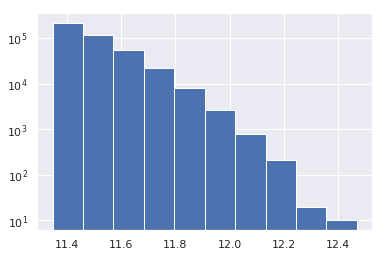

In [10]:
plt.hist(all_smass);
plt.yscale('log')

In [11]:
sorted_idxs = np.argsort(np.array(all_smass))[::-1]

(array([  2.17434000e+05,   1.14615000e+05,   5.37730000e+04,
          2.23440000e+04,   8.12400000e+03,   2.68000000e+03,
          7.86000000e+02,   2.14000000e+02,   2.00000000e+01,
          1.00000000e+01]),
 array([ 11.3458795 ,  11.45840157,  11.57092364,  11.68344571,
         11.79596777,  11.90848984,  12.02101191,  12.13353397,
         12.24605604,  12.35857811,  12.47110018]),
 <a list of 10 Patch objects>)

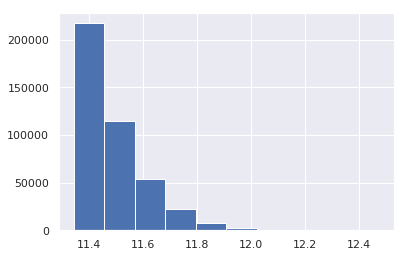

In [12]:
plt.hist(all_smass[sorted_idxs[:int(num_obj)]])

In [13]:
gal_catalog = halo_catalog[non_nan_idxs][sorted_idxs[:int(num_obj)]]

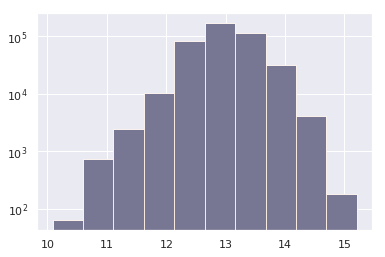

In [14]:
_, bins, _ = plt.hist(np.log10(halo_catalog['halo_mvir']))
plt.hist(np.log10(gal_catalog['halo_mvir']), bins = bins, alpha = 0.3)
plt.yscale('log')

In [15]:
rbins = np.logspace(-1.1, 1.6, 19)
pos = np.c_[gal_catalog['halo_x'], gal_catalog['halo_y'], gal_catalog['halo_z']]

In [16]:
from halotools.mock_observables import tpcf

In [17]:
xi = tpcf(pos, rbins, period=Lbox)

In [18]:
rbc = (rbins[1:]+rbins[:-1])/2.0

[]

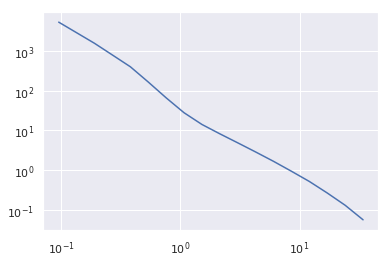

In [19]:
plt.plot(rbc, xi)
plt.loglog()

In [20]:
np.min(halo_catalog['gal_smass'][non_nan_idxs])

11.345879504003795

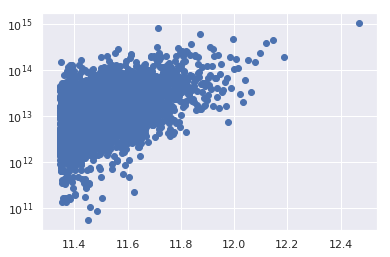

In [21]:
plt.scatter(halo_catalog['gal_smass'][non_nan_idxs][::100], halo_catalog['halo_mvir'][non_nan_idxs][::100])
plt.yscale('log')

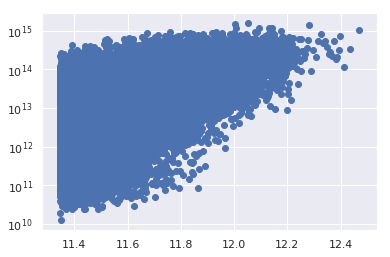

In [22]:
plt.scatter(gal_catalog['gal_smass'], gal_catalog['halo_mvir'])
plt.yscale('log')

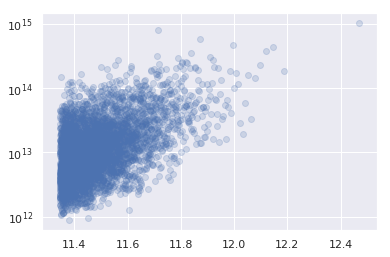

In [23]:
plt.scatter(halo_catalog['gal_smass'][non_nan_idxs][::100], halo_catalog['halo_mpeak'][non_nan_idxs][::100], alpha = 0.2)
plt.yscale('log')

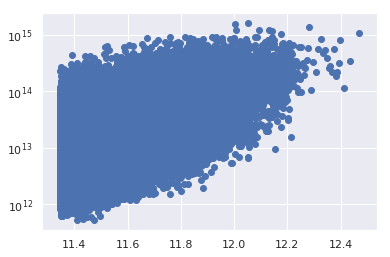

In [24]:
plt.scatter(gal_catalog['gal_smass'], gal_catalog['halo_mpeak'])
plt.yscale('log')

In [25]:
np.min(halo_catalog['halo_mpeak']), np.min(halo_catalog[non_nan_idxs]['halo_mpeak'])#, np.min(gal_catalog['halo_mpeak']))

(5.2225999e+11, 5.2225999e+11)

In [26]:
smf = np.genfromtxt('/scratch/users/swmclau2/DR10_cBOSS_WISE_SMF_z0.45_0.60_M7.dat', skip_header=True)[:,0:2]

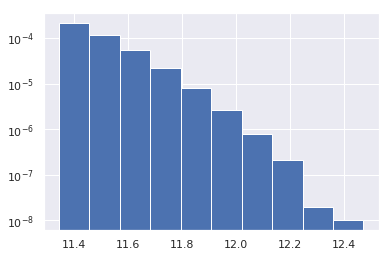

In [27]:
plt.hist(gal_catalog['gal_smass'], weights=np.ones_like(gal_catalog['gal_smass'])*(1./(1000**3) ));
plt.yscale('log')

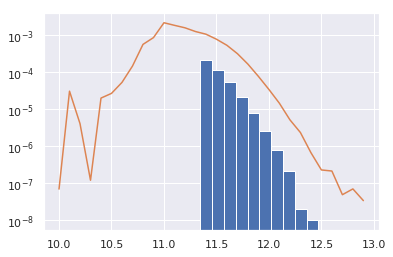

In [28]:
plt.hist(all_smass, weights=np.ones_like(all_smass)*(1./(1000**3) ));
plt.plot(smf[:,0], smf[:,1])
plt.yscale('log')